In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Model
from keras.layers import Conv2D, Input, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input, ReLU,BatchNormalization,LeakyReLU,Identity
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-31 09:11:03.790008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [6]:
from PIL import Image, ImageDraw, ImageFont

font_path = '../dados/targa/Targa.ttf'

In [7]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (180, 50)  # Change size to (height, width)
    font_size = 24
    num_parts = 7

    # Create a blank white image
    image = Image.new('L', size, 255)  # 'L' mode for grayscale

    # Load the custom font
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Calculate positions for each part
    part_width = size[0] / num_parts
    horizontal_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    horizontal_positions = horizontal_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_height = text_bbox[3] - text_bbox[1]
    text_y = (size[1] - text_height) // 2

    # Draw each letter at the calculated position
    for char, x in zip(text, horizontal_positions):
        char_bbox = draw.textbbox((0, 0), char, font=font)
        char_width = char_bbox[2] - char_bbox[0]
        char_x = x - char_width // 2  # Center the character horizontally within its part
        draw.text((char_x, text_y), char, font=font, fill=0)

    # Convert to numpy array if needed for further processing with OpenCV
    captcha_image = np.array(image)

    return captcha_image

In [8]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [9]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['txt_content'] = df['txt_content'].apply(lambda x: x + ' ' if len(x) == 6 else x)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = (Y.astype('float32') - 127.5)  / 127.5
  return X,Y

X_train, Y_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

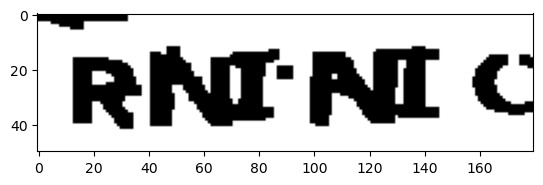

In [10]:
plt.imshow(X_train[0], cmap='gray')

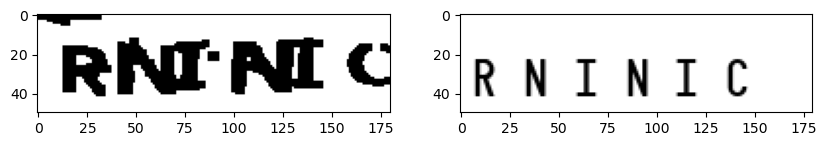

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [12]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

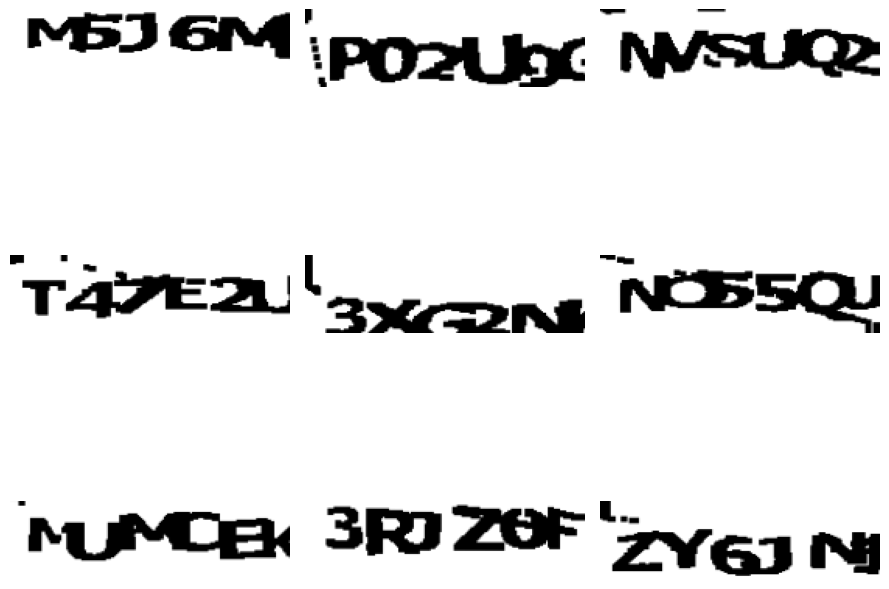

In [13]:
augmented_images, augmented_labels = next(augmented_data_generator)

# Display the first few augmented images and their corresponding labels
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [15]:
#Camada Convolution-BatchNorm-ReLu
def CK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True):
    '''
        filters: quantidade de filtros
        kernel_size 3x3 | strides 1x1 | padding same | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''

    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = actf(x)
        return x
    return layer

In [16]:
def crop_and_concat(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return concatenate([x1, x2_cropped])

In [17]:
def generator(input_nc, output_nc, ngf, num_blocks=1, num_downsample=3):
    # Aqui, definimos o modelo gerador
    
    # Ele deve receber uma imagem (img_size,img_size,input_nc)
    inputs = Input(shape=(50, 180, input_nc))

    # --------------- START ENCODER --------------------------

    x = inputs

    # Uma convolucao eh aplicada inicialmente sem o batch_norm
    x = CK(ngf,use_batch_norm=False)(x)
    # img_shape = img_size/2,img_size/2,ngf

    # Aqui implementamos o caminho onde a dimensao da imagem vai diminuindo
    #Armazenamos as skip connections
    skips = []
    for i in range(num_downsample + num_blocks - 1):
        # Como o numero de filtros vai aumentando exponencialmente, existe um momento em que o crescimento eh cessado e a qtd se torna constante
        # Este e o momento em que i+1 >= num_downsample
        # A partir dai, o numero de filtros nao diminui
        expo = min(i+1,num_downsample)
        # Aplicamos convolucao com o numero de filtros escolhido
        x = CK(ngf*(2**(expo)))(x)
        # Guardamos a coneccao
        skips.append(x)
    
    # --------------- FIM   ENCODER --------------------------
    '''
    Aqui, a imagem esta no formato:
    img_shape = img_size/(num_downsample + num_blocks),img_size/(num_downsample + num_blocks),ngf*(2**(expo))
    
    '''
    # --------------- START DECODER --------------------------
    # As conexoes sao processadas de tras pra frente, ja que a ultima skip gerada vai se ligar com a primeira camada do decoder
    skips = list(reversed(skips))


    # Para as skips que sobraram, devemos conecta-las a camadas sem dropout
    for skip in skips:
        x = crop_and_concat(skip,x)
        # x = Concatenate()([x, skip])
        x = CK(ngf * (2 ** i),downsample=False)(x)
    
    #    img_shape = img_size/(2),img_size/(2),ngf*(2**(expo))
    # --------------- FIM   DECODER --------------------------

    # Por fim, uma ultima convolucao com TanH para gerar o resultado final
    # Numero de canais = output_nc  = 3 = RGB
    x = Conv2DTranspose(ngf, (4, 4),strides=(2,2), activation='relu',padding="same")(x)
    x = Conv2D(ngf, (3, 1),strides=(1,1), activation='relu')(x)
    output = Conv2D(output_nc, (1, 1),strides=(1,1), activation='tanh')(x)
    return Model(inputs=inputs, outputs=output)

autoencoder = generator(1, 1, 32, num_blocks=3, num_downsample=4)
autoencoder.compile(optimizer=Adam(2e-4, beta_1=0.5,beta_2=0.999), loss=MeanSquaredError(),metrics=[rmse,psnr])
autoencoder.summary()

2024-07-31 09:11:11.627050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13742 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 180, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 25, 90, 32)           544       ['input_1[0][0]']             
                                                                                                  
 identity (Identity)         (None, 25, 90, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 25, 90, 32)           0         ['identity[0][0]']            
                                                                                              

In [18]:
checkpoint = ModelCheckpoint(
    'model_MSE_aug_best_unet.tf',
    monitor='val_rmse',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [19]:
history = autoencoder.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/300


2024-07-31 09:11:15.750191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-31 09:11:23.505282: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9e1f560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-31 09:11:23.505324: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-31 09:11:23.509922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 09:11:23.624505: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - ETA: 0s - loss: 0.1110 - rmse: 0.3185 - psnr: 10.1359
Epoch 1: val_rmse improved from inf to 0.52718, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 194s 1s/step - loss: 0.1110 - rmse: 0.3185 - psnr: 10.1359 - val_loss: 0.2779 - val_rmse: 0.5272 - val_psnr: 5.5609
Epoch 2/300
125/125 [==============================] - ETA: 0s - loss: 0.0693 - rmse: 0.2631 - psnr: 11.6061
Epoch 2: val_rmse improved from 0.52718 to 0.30684, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 157s 1s/step - loss: 0.0693 - rmse: 0.2631 - psnr: 11.6061 - val_loss: 0.0941 - val_rmse: 0.3068 - val_psnr: 10.2622
Epoch 3/300
 33/125 [======>.......................] - ETA: 52s - loss: 0.0580 - rmse: 0.2408 - psnr: 12.3713

In [ ]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

In [ ]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 180), cmap="gray")
        plt.title("Y")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 180), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

In [ ]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

In [ ]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)